# Pel·lícules de Netflix, Prime Video, Hulu i Disney+

1600123 | Alba Fernández Coronado

In [1]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections as col
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats
import random as rand
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
import time
from yellowbrick.target import FeatureCorrelation
import statistics as st
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

### EDA I PREPROCESSING

In [2]:
# Obrint el dataset
dataset = pd.read_csv('./MoviesOnStreamingPlatforms.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.info() # Entenent els tipus de variables de cada atribut
dataset.head()

Mida de les dades: (9515, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       9515 non-null   int64 
 1   ID               9515 non-null   int64 
 2   Title            9515 non-null   object
 3   Year             9515 non-null   int64 
 4   Age              5338 non-null   object
 5   Rotten Tomatoes  9508 non-null   object
 6   Netflix          9515 non-null   int64 
 7   Hulu             9515 non-null   int64 
 8   Prime Video      9515 non-null   int64 
 9   Disney+          9515 non-null   int64 
 10  Type             9515 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 817.8+ KB


,Unnamed: 0,ID,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,0,1,The Irishman,2019,18+,98/100,1,0,0,0,0
1,1,2,Dangal,2016,7+,97/100,1,0,0,0,0
2,2,3,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0,0
3,3,4,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0,0
4,4,5,Roma,2018,18+,94/100,1,0,0,0,0


In [3]:
#S'eliminen les columnes innecessàries del dataset
dataset_df = dataset.drop(["Unnamed: 0", "ID"], axis=1)
#Es mira la columna Type --> Type Movie: 0 TV Show: 1
print("Tipus de valors: ",dataset_df['Type'].nunique()) #quants tipus de valors hi ha: 1
print("Valors únics: ",dataset_df['Type'].unique()) #quins són els valors únics: 0
dataset_df = dataset_df.drop(["Type"], axis=1) #L'eliminem pq totes les pelis són Movies
dataset_df.head()

Tipus de valors:  1
Valors únics:  [0]


,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
0,The Irishman,2019,18+,98/100,1,0,0,0
1,Dangal,2016,7+,97/100,1,0,0,0
2,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0
3,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0
4,Roma,2018,18+,94/100,1,0,0,0


Text(0.5, 1.0, "Any d'estreno de les pel·lícules")

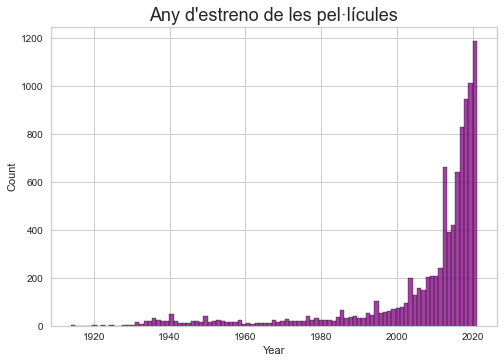

In [4]:
#fer grafic dels anys de les pelis
sns.histplot(data=dataset_df, x="Year", color="purple")
plt.title("Any d'estreno de les pel·lícules", fontsize=18)

In [5]:
#Mirem el percentatge de valors Null
(dataset_df.isnull().sum()/len(dataset))*100

Title               0.000000
Year                0.000000
Age                43.899107
Rotten Tomatoes     0.073568
Netflix             0.000000
Hulu                0.000000
Prime Video         0.000000
Disney+             0.000000
dtype: float64

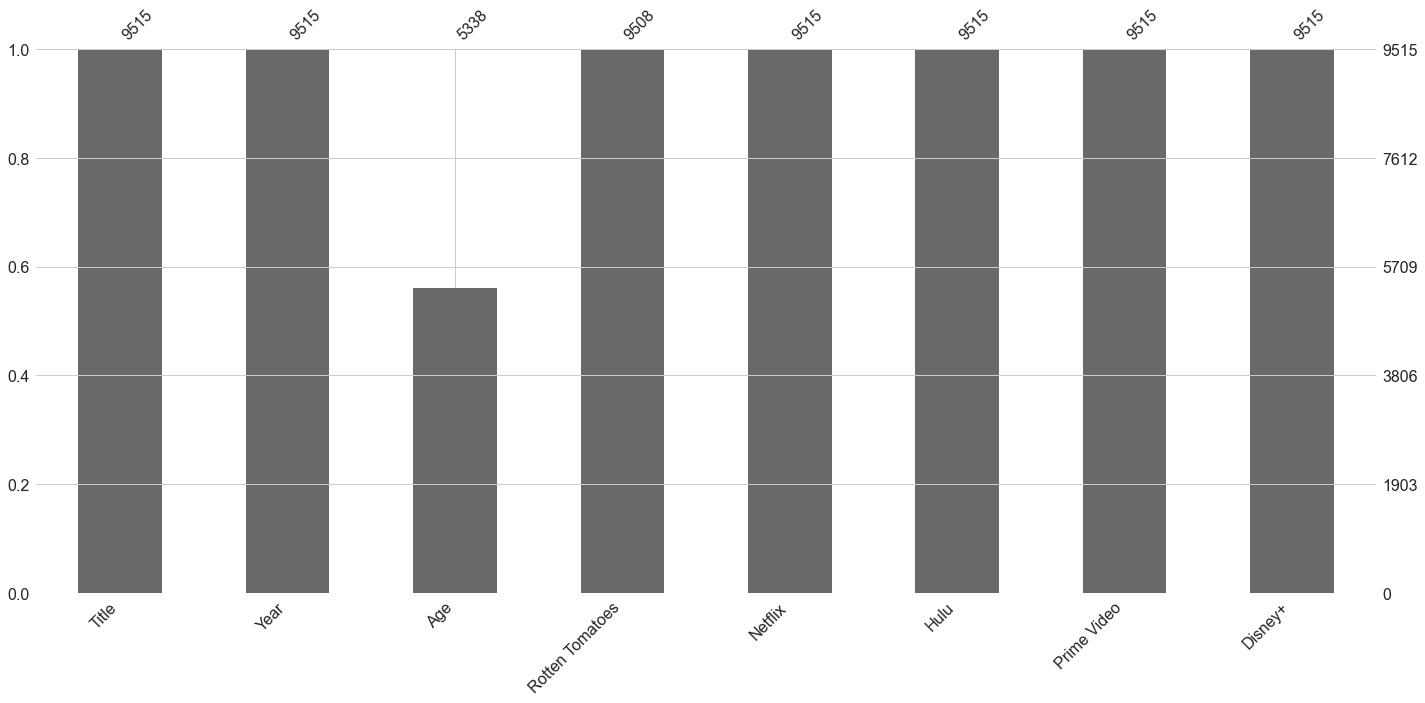

In [6]:
import missingno as msno
# plotting the number of rows with entries per column
msno.bar(dataset_df)

In [7]:
#Eliminem les files que continguin NaNs a la variable resposta (Rotten Tomatoes) pq no ens interessen
dataset_df = dataset_df[dataset_df['Rotten Tomatoes'].notna()]

(dataset_df.isnull().sum()/len(dataset_df))*100

Title               0.000000
Year                0.000000
Age                43.857804
Rotten Tomatoes     0.000000
Netflix             0.000000
Hulu                0.000000
Prime Video         0.000000
Disney+             0.000000
dtype: float64

In [8]:
#Tractem les dades tipus objecte
dataset_df['Rotten Tomatoes'] = (dataset_df['Rotten Tomatoes'].str.split("/", n=1).str[0].astype("int"))/100

#Tractem la columna Age
dataset_df['Age'].fillna(0, inplace=True) #omplim els nans amb 0
edats = {"18+": 18, "7+": 7, "13+": 13, "16+": 16, "all": 0, 0:0}
dataset_df['Age'] = [edats[item] for item in dataset_df['Age']]
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              9508 non-null   int64  
 3   Rotten Tomatoes  9508 non-null   float64
 4   Netflix          9508 non-null   int64  
 5   Hulu             9508 non-null   int64  
 6   Prime Video      9508 non-null   int64  
 7   Disney+          9508 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 668.5+ KB


In [26]:
#Ara que ja tenim les edats en int i sense cap NaN, afegim una columna per mirar si les pelis tenen restricció d'edat o no
dataset_df['Age_Restricted'] = np.where(dataset_df['Age'] == 0, 0, 1)
dataset_df.head()

,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Age_Restricted
0,The Irishman,2019,18,0.98,1,0,0,0,1
1,Dangal,2016,7,0.97,1,0,0,0,1
2,David Attenborough: A Life on Our Planet,2020,7,0.95,1,0,0,0,1
3,Lagaan: Once Upon a Time in India,2001,7,0.94,1,0,0,0,1
4,Roma,2018,18,0.94,1,0,0,0,1


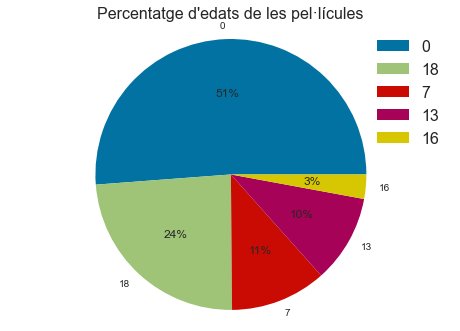

In [25]:
#Fer gràfic de les edats de les pelis
count_edats = [dataset_df['Age'].value_counts()]
noms_edats = ["0","18","7","13","16"]
plt.pie(count_edats, labels=noms_edats, autopct='%1.0f%%')
plt.axis("equal")
plt.title("Percentatge d'edats de les pel·lícules", fontsize=16)
plt.legend(loc='best', facecolor='w', fontsize=16)
plt.show()

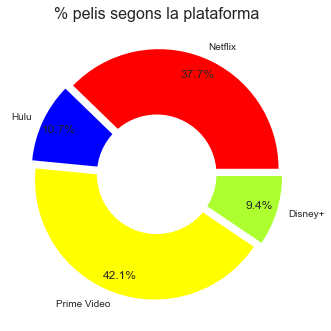

In [19]:
#Fem un gràfic segons el percentatge de pelis que té cada plataforma
Plataformes = ['Netflix', 'Hulu', 'Prime Video', 'Disney+']
rows = len(dataset_df.axes[0])
nombre_pelis = [dataset_df['Netflix'].sum()/rows, dataset_df['Hulu'].sum()/rows, 
                dataset_df['Prime Video'].sum()/rows, dataset_df['Disney+'].sum()/rows]
colors = ['#FF0000', '#0000FF', '#FFFF00', '#ADFF2F']
explode = (0.05, 0.05, 0.05, 0.05)

# Pie Chart
plt.pie(nombre_pelis, colors=colors, labels=Plataformes,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('% pelis segons la plataforma', fontsize=16)
  
# Displaying Chart
plt.show()

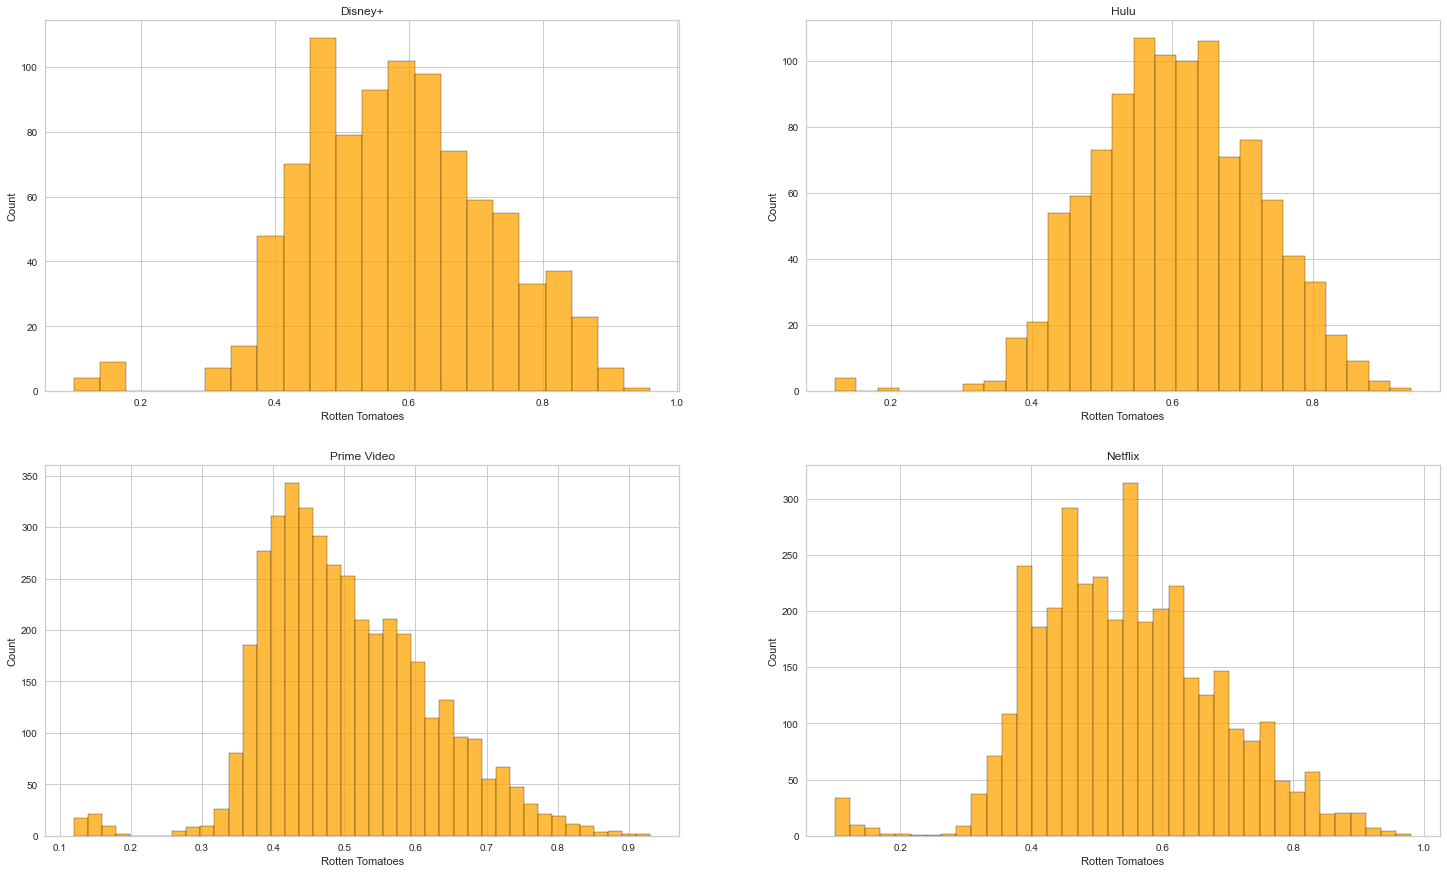

In [12]:
#Ara fem un gràfic de les puntuacions de les pelis segons la plataforma
#Disney+
dataset_Disney = dataset_df[dataset_df['Disney+'] ==1]
punt_disney = dataset_Disney['Rotten Tomatoes']
#Hulu
dataset_Hulu = dataset_df[dataset_df['Hulu'] ==1]
punt_hulu = dataset_Hulu['Rotten Tomatoes']
#Prime Video
dataset_Prime = dataset_df[dataset_df['Prime Video'] ==1]
punt_prime = dataset_Prime['Rotten Tomatoes']
#Netflix
dataset_Netflix = dataset_df[dataset_df['Netflix'] ==1]
punt_netflix = dataset_Netflix['Rotten Tomatoes']

#Fem els histogrames
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(2, 2, 1) 
ax1.set_title('Disney+') 
ax2 = fig.add_subplot(2, 2, 2) 
ax2.set_title('Hulu')
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('Prime Video')
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Netflix')
sns.histplot(data=dataset_Disney, x='Rotten Tomatoes', color="orange", ax=ax1)
sns.histplot(data=dataset_Hulu, x='Rotten Tomatoes', color="orange", ax=ax2)
sns.histplot(data=dataset_Prime, x='Rotten Tomatoes', color="orange", ax=ax3)
sns.histplot(data=dataset_Netflix, x='Rotten Tomatoes', color="orange", ax=ax4)
plt.show()

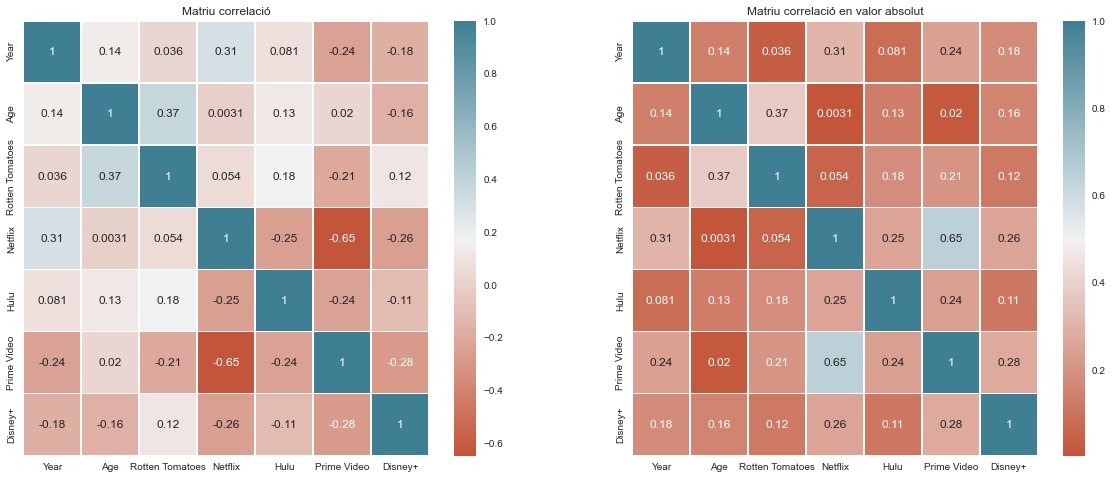

In [13]:
# Estudi de la correlació entre els atributs
correlacio = dataset_df.corr()

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 2, 1) 
ax1.set_title('Matriu correlació') 
ax2 = fig.add_subplot(1, 2, 2) 
ax2.set_title('Matriu correlació en valor absolut')

sns.heatmap(correlacio, annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200), ax=ax1)
sns.heatmap(abs(correlacio), annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200), ax=ax2)
plt.show()

In [14]:
#S'agafen tots els atributs que no siguin object
NoObj_data = dataset_df[dataset_df.select_dtypes(exclude=['object']).columns]

# Agafem la intersecció entre el dataset_df i el dataset sense atributs objecte per tractar els outliers posteriorment
intersect = list(set(dataset_df.columns).intersection(list(NoObj_data.columns)))
NoObj_data = dataset_df[intersect]

NoObj_data.describe()

,Netflix,Rotten Tomatoes,Year,Prime Video,Hulu,Disney+,Age
count,9508.000000,9508.000000,9508.000000,9508.000000,9508.000000,9508.000000,9508.000000
mean,0.387884,0.535450,2007.416386,0.432583,0.110118,0.096971,6.940261
std,0.487293,0.131977,19.134883,0.495460,0.313053,0.295934,7.757894
min,0.000000,0.100000,1914.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.440000,2006.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.520000,2015.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.620000,2018.000000,1.000000,0.000000,0.000000,16.000000
max,1.000000,0.980000,2021.000000,1.000000,1.000000,1.000000,18.000000


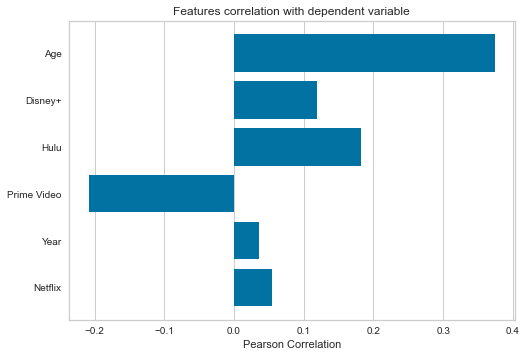

In [15]:
# Correlacio dels atributs amb la variable objectiu (només dels atributs numèrics)
X = NoObj_data.drop(['Rotten Tomatoes'], axis=1)
Y = NoObj_data['Rotten Tomatoes']
feature_names = list(X.columns)
visualizer = FeatureCorrelation(labels = feature_names)
visualizer.fit(X, Y)
visualizer.poof()

In [ ]:
#Ara que ja tenim X i Y separades, Normalitzem les dades
scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X))
X_cols = X.columns
X_scale.columns = X_cols

In [ ]:
#Estudi dels outliers

MiceImputed = NoObj_data.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(NoObj_data)

# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.05)
Q3 = MiceImputed.quantile(0.95)
IQR = Q3 - Q1
total_outlier_num = ((NoObj_data < (Q1 - 1.5 * IQR)) | (NoObj_data > (Q3 + 1.5 * IQR))).sum()
print(total_outlier_num)

# Removing outliers from the dataset
# dataset_cp = dataset_cp[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
# dataset_cp.info()

#El dataset no té outliers, per tant, no els hem de tractar

In [ ]:
#Igualment, es fa un pca per visualitzar els outliers
model = PCA(n_components=3)
model.fit(X_scale)
data_pca = pd.DataFrame(
    data = model.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3'])
X_pca = model.transform(X_scale)

# Percentatge de variança de cada component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca.columns)) + 1, model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('% variança explicat');

#Conclusió: com les variances són molt baixes, no val la pena fer un PCA.

### MODEL SELECTION